In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

!pip install optuna
import optuna

import dataProcess

from datetime import datetime

import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.4 MB/s eta 0:00:00


In [2]:
# data preprocessing

#start = datetime(2024, 1, 3).date()
#end = datetime(2024, 4, 11).date()
#hourly ='weatherstats_toronto_hourly.csv'
#daily ='weatherstats_toronto_daily.csv'
hourly = 'weatherstats_toronto_hourly_10_yr.csv'
daily = 'weatherstats_toronto_daily_10_yr.csv'
start = datetime(2014, 4, 15).date()
end = datetime(2024, 4, 11).date()
data = dataProcess.generateDataNoLoader(hourly, daily, start, end)
train_data = data['train']
val_data = data['validation']
test_data = data['test']

In [3]:
#accuracy func
def accuracy(model, data):
    batch_size = 100
    totalDiff = 0.0
    count = 0
    loader = DataLoader(data, batch_size=batch_size)
    for data, target in loader:
        count = count + len(target)
        z = model(data)

        totalDiff += torch.sum(torch.abs(target - z))
    return(totalDiff / count)

In [4]:
#define model
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        #recurrent layer - stacked
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=2)
        #fully connected layer - 3 layers - layer size redux for training time purposes
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.fc3 = nn.Linear(int(hidden_size/2), output_size)
        self.relu = nn.ReLU()

    def forward(self, X):
        # Initialize hidden state
        X = X.to(torch.float32)
        h_0 = torch.zeros(2, X.size(0), self.hidden_size).to(X.device)
        c_0 = torch.zeros(2, X.size(0), self.hidden_size).to(X.device)
        # Forward pass through RNN
        #print(X.shape)
        #print(h_0.shape)
        output, (h_n, c_n) = self.lstm(X, (h_0,c_0))

        #get output of the RNN at the last timestep
        lstm_output_last = output[:, -1, :]
        # Apply fully connected layer to the output of the last timestep
        out = self.fc1(lstm_output_last)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = torch.squeeze(out)

        return out

In [5]:
def train_model(model, trainData, valData, lr=.002, batchSize=10, epochs=100, v=True):
  train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=False)
  val_loader = DataLoader(val_data, batch_size=batchSize, shuffle=False)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  model.train()
  for epoch in range(epochs):
    total_loss = 0

    for inputs, targets in train_loader:

      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)

      #print(outputs.shape)
      #print(targets.shape)
      #print(outputs.shape)

      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    if v:
      print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {total_loss / len(train_loader):.4f}')

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()
    if v:
      print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {total_val_loss / len(val_loader):.4f}')

In [6]:
def objective(trial):
    lr = trial.suggest_float('lr', .001, .05)
    batchSize = trial.suggest_int('batchSize', 5, 100)
    epochs = trial.suggest_int('epochs', 5, 100)
    hidden_size = trial.suggest_int('hidden_size', 10, 312)
    model = MyLSTM(hidden_size=hidden_size, input_size = 13, output_size = 1)
    train_model(model, train_data, val_data, lr=lr, batchSize=batchSize, epochs=epochs, v=False)
    return accuracy(model, data['validation'])

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

[I 2024-04-19 08:30:03,940] A new study created in memory with name: no-name-00504bdf-371d-46a4-a19b-96ed64102f8b
[I 2024-04-19 08:32:52,488] Trial 0 finished with value: 9.065667152404785 and parameters: {'lr': 0.0010845841497907445, 'batchSize': 60, 'epochs': 49, 'hidden_size': 301}. Best is trial 0 with value: 9.065667152404785.
[I 2024-04-19 08:33:07,848] Trial 1 finished with value: 9.264687538146973 and parameters: {'lr': 0.02938796222145545, 'batchSize': 59, 'epochs': 7, 'hidden_size': 255}. Best is trial 0 with value: 9.065667152404785.
[I 2024-04-19 08:35:56,805] Trial 2 finished with value: 9.264750480651855 and parameters: {'lr': 0.04419241574140152, 'batchSize': 27, 'epochs': 42, 'hidden_size': 206}. Best is trial 0 with value: 9.065667152404785.
[I 2024-04-19 08:40:23,264] Trial 3 finished with value: 9.264102935791016 and parameters: {'lr': 0.03231445241545215, 'batchSize': 43, 'epochs': 47, 'hidden_size': 152}. Best is trial 0 with value: 9.065667152404785.
[I 2024-04-19

In [7]:
print(study.best_params)

model = MyLSTM(hidden_size=study.best_params['hidden_size'], input_size = 13, output_size = 1)
train_model(model, train_data, val_data, lr=study.best_params['lr'], batchSize=study.best_params['batchSize'], epochs=study.best_params['epochs'])
#{'lr': 0.0017342906270668042, 'batchSize': 61, 'epochs': 52, 'hidden_size': 227}
print(accuracy(model, data['test']))
torch.save(model, 'model.pt')#save model data

{'lr': 0.0017342906270668042, 'batchSize': 61, 'epochs': 52, 'hidden_size': 227}
Epoch [1/52], Training Loss: 144.6267
Epoch [1/52], Validation Loss: 114.9146
Epoch [2/52], Training Loss: 118.5564
Epoch [2/52], Validation Loss: 114.7255
Epoch [3/52], Training Loss: 117.6459
Epoch [3/52], Validation Loss: 114.3962
Epoch [4/52], Training Loss: 135.9601
Epoch [4/52], Validation Loss: 120.6644
Epoch [5/52], Training Loss: 123.1319
Epoch [5/52], Validation Loss: 113.4754
Epoch [6/52], Training Loss: 118.8160
Epoch [6/52], Validation Loss: 113.2624
Epoch [7/52], Training Loss: 117.0459
Epoch [7/52], Validation Loss: 113.4658
Epoch [8/52], Training Loss: 116.1291
Epoch [8/52], Validation Loss: 113.2733
Epoch [9/52], Training Loss: 115.0227
Epoch [9/52], Validation Loss: 112.7682
Epoch [10/52], Training Loss: 115.1466
Epoch [10/52], Validation Loss: 112.8706
Epoch [11/52], Training Loss: 114.6520
Epoch [11/52], Validation Loss: 112.4320
Epoch [12/52], Training Loss: 113.8832
Epoch [12/52], Val

In [8]:
def collect_data(model, data_loader, device):
  model.eval()
  total_mae = 0
  count = 0
  predictions = []
  actuals = []


  with torch.no_grad():
    for inputs, targets in data_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs, targets = inputs.float(), targets.float()
      outputs = model(inputs)
      count += 1

      predictions.extend(outputs.view(-1).detach().cpu().numpy())
      actuals.extend(targets.view(-1).detach().cpu().numpy())


  return predictions, actuals

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
batchSize= 7
test_loader = DataLoader(test_data, batch_size=batchSize, shuffle=False)
predictions, actuals = collect_data(model, test_loader, device)

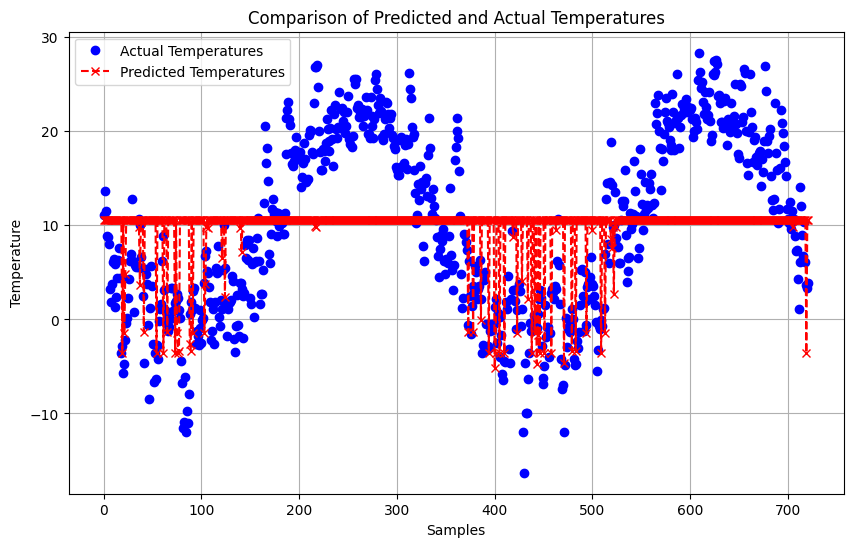

In [9]:
def plot_predictions_vs_actuals(predictions, actuals):
  plt.figure(figsize=(10, 6))
  plt.plot(actuals, label='Actual Temperatures', color='blue', marker='o', linestyle='')
  plt.plot(predictions, label='Predicted Temperatures', color='red', linestyle='--', marker='x')
  plt.title('Comparison of Predicted and Actual Temperatures')
  plt.xlabel('Samples')
  plt.ylabel('Temperature')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_predictions_vs_actuals(predictions, actuals)